#### Evaluating doc2vec vectors for wiki10 documents (wikipedia article text with multiple class labels)

In [1]:
# import modules & set up logging
from pathlib import Path
import re
import string 
from itertools import islice
import multiprocessing
import json
import numpy as np
import pandas as pd 
from sklearn.manifold import TSNE, MDS
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
import seaborn as sns
import matplotlib.pyplot as plt 
from gensim.models import Doc2Vec
from sklearn.metrics import pairwise 
init_notebook_mode(connected=True)
%matplotlib inline 

In [2]:
DATA_DIR = Path('../../data/wiki10')
TEXT_DIR = DATA_DIR / 'text' 
TAGS_PATH = DATA_DIR / 'tags.json'
MODEL_PATH = DATA_DIR / 'doc2vec.model'

#### Evaluation

We will now evaluate distance between documents by reducing dimensions with T-SNE and plotting the result. We can also get an idea of how these "clusters" compare to human categorisation by loading our document labels and overlaying.

Loading model and meta data containing tag information

In [3]:
model = Doc2Vec.load(str(MODEL_PATH))

In [4]:
with TAGS_PATH.open() as input_fileobj:
    tags = json.load(input_fileobj) 

Create DataFrame from meta dictionary containing, ensuring row order is the same as doc_vectors matrix
* id: document filename
* title: wikipedia document title
* user_count: number of people which tagged the document
* tags: dict of {'tag': tag_score} where tag score is the proportion of users which assigned that tag
* tag: tag with highest score 
* mapped_tag: mapped_tag created in 01_cluster_rags

In [5]:
meta_records = [tags[doc_id] for doc_id in model.docvecs.offset2doctag]

In [6]:
df = pd.DataFrame.from_records(meta_records)

Append doc_vectors as a new column to simplify sampling/reordering data. Can recover ndarray with vstack. (Alternative would be to keep objects separate and pass df index as row index to doc vectors after df manipulation) 

In [7]:
df['doc_vectors'] = list(model.docvecs.doctag_syn0)  

In [8]:
type(df.doc_vectors[0]) 

numpy.ndarray

In [9]:
df.head()

,mapped_tag,tag,tags,title,user_count,doc_vectors
0,NA,food,"{'food': 0.4, 'culture': 0.06666666666666667}",Miso soup,15,"[1.02558, -0.148636, 1.14235, -0.0633298, 0.48..."
1,religion,religion,"{'religion': 0.23076923076923078, 'english': 0...",Eucharist,13,"[0.723513, 1.79643, -0.423377, -1.68568, 0.777..."
2,religion,religion,"{'religion': 0.25, 'literature': 0.0625}",Book of Job,16,"[-0.928215, 1.4738, -2.18351, 0.823719, 1.4426..."
3,language,language,{'language': 0.5},Hungarian language,18,"[-0.749106, 1.34593, -0.747539, 0.44013, 0.581..."
4,media,tv,{'tv': 0.4},Undeclared,10,"[0.0455033, 0.747757, 0.467062, 0.128633, 0.20..."


In [10]:
df.tag.value_counts()

history        1428
music           985
programming     940
science         925
philosophy      712
politics        619
religion        605
psychology      605
art             578
health          565
language        483
books           465
math            449
software        443
security        360
design          355
games           349
economics       347
literature      343
travel          343
linux           315
people          306
technology      305
food            304
culture         293
tv              290
web             272
business        272
physics         264
writing         257
               ... 
networking      147
network         144
development     133
opensource      127
graphics        127
theory          110
algorithms      108
mathematics     105
media           105
usa              86
funny            85
computer         83
sociology        82
english          82
algorithm        78
list             74
linguistics      72
game             67
words            66


We still have too many classes and observations to visualize effectively so we will sample each of our classes and split them into two groups of tag types, then run TSNE dimensionality reduction and plot. 

In [11]:
group_1 = {'religion', 'economics', 'art', 'music', 'math', 'science', 'film', 'people', 'language'}
group_2 = {'politics', 'history', 'tv', 'programming', 'technology', 'philosophy', 'literature', 'games', 'food' }

In [12]:
def sample_tags(df, tags, n):
    ''' return a view of dataframe containing rows from sample of tag types'''
    df_sample = (df.loc[df.tag.isin(tags)]
                   .groupby('tag')
                   .apply(lambda x: x.sample(n))
                   .reset_index(level=0, drop=True))  # removing tags from multindex
    return df_sample

In [43]:
def plot_tsne(df):
    # compute TSNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=0)
    tsne_results = tsne.fit_transform(np.vstack(df['doc_vectors']))

    # plot results
    traces = []
    for tag_type in df.tag.unique():
        trace = go.Scatter(
            x=tsne_results[df.tag==tag_type,0],
            y=tsne_results[df.tag==tag_type,1],
            text=df.loc[df.tag==tag_type,"title"],
            hoverinfo='text',
            mode='markers',
            name=tag_type, 
            marker=dict(
                size=5,
                opacity=0.5
            )
        )
        traces.append(trace)
        
    layout = go.Layout(
        hovermode='closest',
        width=650,
        height=500,
        margin=go.Margin(
            t=10
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)
    #py.image.ishow(fig)

In [44]:
%%time
plot_tsne(sample_tags(df, tags=group_1, n=200))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.012s...
[t-SNE] Computed neighbors for 1800 samples in 1.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 1.636416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.921768
[t-SNE] Error after 300 iterations: 1.429623


CPU times: user 29.8 s, sys: 1.14 s, total: 30.9 s
Wall time: 31.9 s


In [55]:
%%time
plot_tsne(sample_tags(df, tags=group_2, n=200))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.004s...
[t-SNE] Computed neighbors for 1800 samples in 1.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 1.638291
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.237312
[t-SNE] Error after 300 iterations: 1.421418


CPU times: user 29.6 s, sys: 1.02 s, total: 30.6 s
Wall time: 30.9 s


Even in 2 dimensions there is a clear separation between some manually labelled classes from the unsupervised doc2vec. 

Also notice the tight groups of varyiable tag types which do not really belong to any one particular "cluster". Hovering over them reveals they often refer to articles which contain lists of items e.g. **"list of literary awards"**, **"list of software development philosophies"**. Whilst the lists do appear to be very specific to a single domain, the sentences input to doc2vec algorithm for these pages will not be full sentences, only single words/phrases and so the learnt weights for the document vector may suffer, and as a result we see them sitting in "no-mans land".

We will now look at the distance between the labelled tags types and their document vectors in more detail.

Finding all tag types which appear >= 200 times to reduce the number of classes we consider.

In [46]:
tags_200 = (df.groupby(['tag'])
              .filter(lambda x: len(x) >= 200)
              .tag
              .unique())  

Sampling all tag types in tags_200 and finding "centroid" vector for each tag type. 

In [47]:
centroids = (sample_tags(df, tags=tags_200, n=200)
             .groupby('tag')  
             .apply(lambda x: np.vstack(x.doc_vectors).mean(axis=0)))

In [48]:
df_centroids = pd.DataFrame({
    'tag':centroids.index,
    'doc_vectors':centroids.values
   }) 

In [49]:
df_centroids.head()

,doc_vectors,tag
0,"[-0.0321512, 0.216894, 0.641794, 0.434132, 0.5...",architecture
1,"[-0.182883, -0.0352008, 0.0501076, 0.316987, 0...",art
2,"[-0.183987, 0.588765, -0.138025, 0.159294, 0.7...",books
3,"[0.0160324, 0.604401, 1.24022, -0.310925, 0.47...",business
4,"[0.115322, 0.361536, 0.517129, 0.16672, 0.3778...",culture


Calculating and plotting TSNE for each centroid to visualize distance between each tag 

In [50]:
def plot_scatter_labels(X, Y, labels):
    plt.rcParams["figure.figsize"] = (8,8)
    for x, y, label in zip(X, Y, labels):
        plt.scatter(x, y) 
        plt.text(x, y, label)
    plt.show()

In [51]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=0)
tsne_2d = tsne.fit_transform(np.vstack(df_centroids['doc_vectors']))

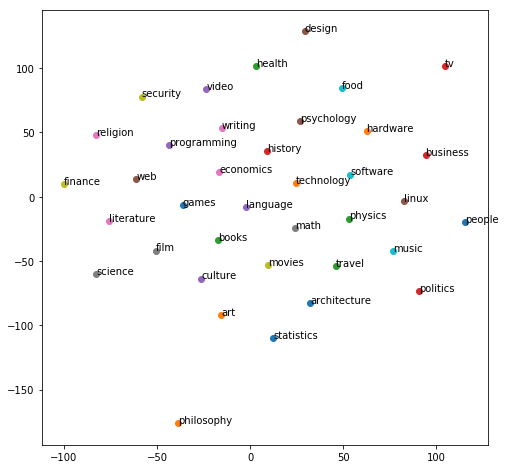

In [52]:
X = tsne_2d[:,0]
Y = tsne_2d[:,1]
labels = df_centroids.tag.values

plot_scatter_labels(X, Y, labels) 

The TSNE algorithm tries to find local trends, but is less effective at capturing global trends. We can see that problem illustrated here as there is a large distance between "physics" and "science", which is counterintuitive. 
https://stats.stackexchange.com/questions/238538

We will try applying a different algorithm for dimensionality reduction (Multi-dimensional scaling) which should better preserve the actual distance between observations. 

In [53]:
mds = MDS(n_components=2, random_state=1)
mds_2d = mds.fit_transform(np.vstack(df_centroids['doc_vectors']))

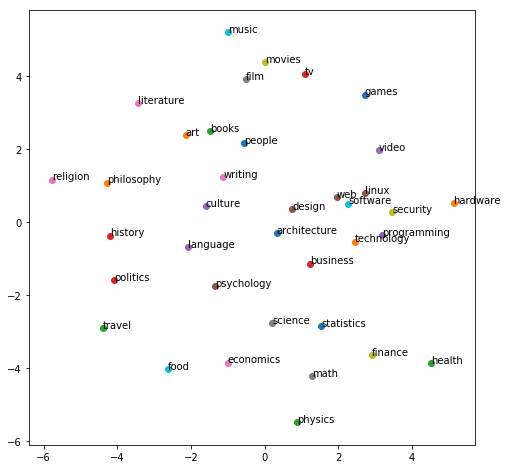

In [54]:
X = mds_2d[:,0]
Y = mds_2d[:,1]
labels = df_centroids.tag.values

plot_scatter_labels(X, Y, labels) 

Using the default euclidean distance with MDS we get a much better result than TSNE, with nearby tag types appearing quite intuitive.

#### TODO
* Apply MDS to raw doc_vectors (not tag_type centroids) to compare with TSNE 
* Compare MDS/TSNE with UMAP as this is supposed to give both good local clustering, and better global distances (and more scalable) 